In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# example data with peaks:
x = np.linspace(-1,3,1000)
data = -0.1*np.cos(12*x)+ np.exp(-(1-x)**2)

#     ___ detection of local minimums and maximums ___

a = np.diff(np.sign(np.diff(data))).nonzero()[0] + 1               # local min & max
b = (np.diff(np.sign(np.diff(data))) > 0).nonzero()[0] + 1         # local min
c = (np.diff(np.sign(np.diff(data))) < 0).nonzero()[0] + 1         # local max
# +1 due to the fact that diff reduces the original index number

# plot
plt.figure(figsize=(12, 5))
plt.plot(x, data, color='grey')
plt.plot(x[b], data[b], "o", label="min", color='r')
plt.plot(x[c], data[c], "o", label="max", color='b')
#plt.plot(x[a], data[a], "o", label="max", color='b')
plt.show()

### the floquet code is given below_

running for N =  30 with 4 processors


/home/mahi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


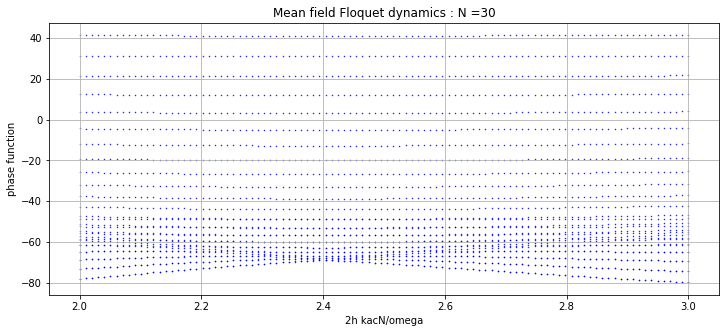

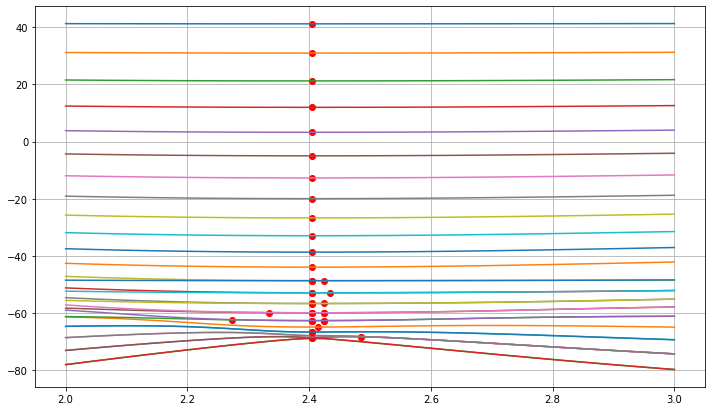

mode is [2.404040404040404]
time taken 0.728853992621104 minute


In [24]:
# Here I have tried to use nearest valued phasefunction

#   Here I have used scatter plot again, but the datafile created here is used 
#   for normal plotting in codes bellow.

import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from multiprocessing import Pool
from numpy.linalg import multi_dot, norm, eig
import math
import time
start = time.time()

from collections import Counter
# Bessel's root of first order
# 2.40482555769577	5.52007811028631	8.65372791291101	11.7915344390142	14.9309177084877

N = 30
kacN = N
h0 = 0.1
omega = 600
w = omega
tsteps = 500

hsteps = 100
h1 = 1/(2. * kacN) * omega * 2.0
h2 = 1/(2. * kacN) * omega * 3.
hs = np.linspace(h1, h2, hsteps)
hpp = (np.ones((N+1,len(hs))) * hs).T
#hpp = np.asarray(hpp)
psi = np.eye(N+1) + 1j * np.zeros((N+1,N+1))
H1 = np.zeros((N+1,N+1))

plotname = 'mfd_fl_h_0-15p5_varies'+str(N)+'real.jpeg'
h_file = 'h_data_N' +str(N) +'.txt'
phase_file = 'phase_data_N' +str(N) +'.txt'
evec_file = 'evec_data_N' +str(N) +'.txt'

def delta_func(x,y):
        if ( x == y ):
            return 1.0
        else:
            return 0.0
        
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]

def mode_value(sample):
    c = Counter(sample)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]
        
def floq_jac(psi0, t, h, h0, H1, H0, w):    
    drive = h0 + h * np.cos(w * t)
    jac = 1j * N * (H0 + drive * H1)    
    return jac
        
def floq_func(psi0, t, h, h0, H1, H0, w):
    floq_h = np.dot(floq_jac(psi0, t, h, h0, H1, H0, w), psi0)
    return floq_h

def floq_evolv(psi,H0,H1,h,w):
    T = 2 * np.pi/w * 2                                   
    t = np.linspace(0,2 * np.pi/w,tsteps)                   
    floqEvolution_mat = np.zeros((N+1,N+1)) + 1j * np.zeros((N+1,N+1))
    
    for m in np.arange(N+1):
        psi0 = psi[m]
        psi_t = odeintw(floq_func,psi0,t,args=(h, h0, H1, H0, w))
        floqEvolution_mat[m] = psi_t[-1]        
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = 1j * np.log(evals + 1j * 0) * w/(2 * np.pi)
    return [h,phasefunc.real,evecs]

if __name__ == '__main__':
    nprocs = 4
    p = Pool(processes = nprocs)          
    print("running for N = ", N, "with",nprocs,"processors")
    start = time.time()       
   
    spin = 0.5 * np.arange(N+1)[-1]
    s = np.arange(-spin,spin+1) 
    H0 = np.diagflat(0.5 * s **2/kacN)  
    for i in range(N+1):
        for j in range(N+1):
            H1[i][j] = 0.5 * (np.sqrt(spin * (spin+1) - s[i] * (s[i]+1)) * delta_func(s[j],s[i]+1)\
                              + np.sqrt(spin * (spin+1) - s[i] * (s[i]-1)) * delta_func(s[j],s[i]-1))
    
    data1 = p.starmap(floq_evolv,[(psi,H0,H1,h,w) for h in hs])
    data = np.asarray(data1,dtype=None).reshape((len(hs),3))
    h_f = data[:,[0]]
    phs_f = data[:,[1]]
    evec_f = data[:,[2]]
    
    
    title = "Mean field Floquet dynamics : N =" + str(N)
    plt.figure(figsize = (12,5))
    for xx in np.arange(len(hs)):
        plt.scatter(2 * hpp[xx] * kacN /w, phs_f[xx][0].real,\
                    color = 'blue', marker='.', s = 0.9)
    plt.title(title)    
    plt.xlabel("2h kacN/omega")
    plt.ylabel("phase function")
    plt.grid()
    #plt.savefig(filename1,dpi=500)
    plt.show()


plt.figure(figsize = (12,7))
prob = np.zeros(N+1)
valley = []

for j in range(N+1):    
    hh = np.zeros(hsteps)
    ph = np.zeros(hsteps)
    hh[0] = data1[0][0]
    ph[0] = data1[0][1][j]
    prev_ph = data1[0][1][j]
    for i in range(1,hsteps):
        hh[i] = data1[i][0]
        ph[i] = find_nearest(data[i][1],np.array([prev_ph]))        
        prev_ph = ph[i]
    a = (np.diff(np.sign(np.diff(ph))) > 0).nonzero()[0] + 1
    #print('a=',2 * hh[a] * kacN/omega)
    valley = np.hstack((valley,(2 * hh[a] * kacN/omega)))
    plt.plot(2 * hh[a] * kacN/omega,ph[a],"o",color='r')
    plt.plot(2 * hh * kacN/omega ,ph)
plt.grid()
plt.show()

mode_vl = mode_value(valley)
print('mode is',mode_vl)

print('time taken',(time.time()-start)/60,'minute')

In [19]:
a = [1,2,3]
b = [4,5]
c = []
a = np.hstack((c,b))
print(a)

[4. 5.]
